Some friends and I undertook a project to use Machine Learning to predict NHL player performance for the coming season based on their production in previous seasons. I recruited Neal Harder and Adam Gignac for their skills and enthusiasm.

We came up with something that worked. It doesn't produce overwhelmingly amazing predictions, but it cranks something out.

My contribution to the project was the ML. What I discovered is that the challenging part was wrangling the data into a form that the ML algorithm could digest.

I'll use the Long Short Term Memory algorithm for this project. Jason Brownlee has a number of LSTM tutorials on his site: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/. This and other of Jason's posts were instrumental to the project.

This notebook is focused on the ML portion of our project, and it's a great companion to the blog post: https://scibbatical.wordpress.com/2018/02/27/building-a-fantasy-hockey-beater/.

Here, we'll use past data to predict goals scored in the 2016-2017 season. We can evaluate the prediciton by comparing it to the actual scoring from that season.

### 

This algorithm can be broken down as:

1. Retrieve data from a database
2. Prepare data for ML model training
3. Train model and predict
4. Evaluate model performance

Let's get started.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking

import matplotlib.pyplot as plt

import csv

%matplotlib inline

Using TensorFlow backend.


## 1. Retrieve data from a database
## &
## 2. Prepare data for ML model training

So, I'm already mixing steps here. Sorry. Certain things are easier to do up front instead of waiting until later.

We're working with an SQLite database. This page is a useful _basic_ SQLite in Python tutorial: http://zetcode.com/db/sqlitepythontutorial/

The database includes data from the 2005-2006 season through 2016-2017. We're interested in forwards who have scored more than 50 points in a season. Find those players:

In [2]:
db_name = "NHLseasonML_mini.db"

# connect to our database
conn = sqlite3.connect(db_name)

with conn:
    # get the cursor so we can do stuff
    cur = conn.cursor()
    
    # SQLite statement to retreive the data in question (forwards who have
    # scored more than 50 points in a season):
    cur.execute("SELECT playerId FROM s_skater_summary WHERE points > 50 AND playerPositionCode IN ('C', 'F', 'L', 'R')")
    
    # Put selected playerIds in an array (playerId is a unique identifier)
    data = np.array(cur.fetchall())

# data contains multiple entries for some players (those who have scored
# more than 50 points in multiple seasons) - isolate unique values
players = np.unique(data)

# show number of unique players
print(players.shape[0], "players identified")
   

301 players identified


We'll use this list of players when we extract the stats data from the database.

I'll define a function that extracts stats from the database and applys a _lag_ to our stat of interest.

But what's a _lag_? In the way this problem is framed, the stats of a given year are  independant variables. The responding variable is the value of a statistic (goals, in this case) in a following season. The lag represents the number of seasons ahead that are considered. This business about lag has to do with preparing data for ML.

The function:


In [3]:
def extractlag(player, stat4lag, lag ):
    """
    For now, the stat categories extracted will be hard-coded.
    
    I've also hard-coded the database name and the table name from the database.
    
    player = playerId from the database
    
    stat4lag = name of stat to be lagged (string)
    
    lag = integer value for lagging (must be positive)


    """

    db_name = "NHLseasonML.db"
    
    # connect to our database that will hold everything
    conn = sqlite3.connect(db_name)

    with conn:
        # get the cursor so we can do stuff
        cur = conn.cursor()

        # Sidney Crosby has playerId = 8471675
        # Notice that the stats extracted are hard-coded...
        cur.execute("SELECT seasonId, points, goals, ppPoints, shots, timeOnIcePerGame, assists, gamesplayed, playerId FROM s_skater_summary WHERE playerId=?", [player])

        data = cur.fetchall()
    
    if len(data) > 0: # only lag if some data is retreived

        # import data into a dataframe
        df = pd.DataFrame(data)

        # name the columns of df
        df.columns = ('year', 'points', 'goals', 'ppPoints', 'shots', 'timeOnIcePerGame', 'assists', 'games', 'id')
        # create a dataframe of shifted values - these are lagged w.r.t. the original dataframe
        dfshift = df.shift(lag)
        # name the columns of the shifted df
        dfshift.columns = ('yearlag', 'pointslag', 'goalslag', 'ppPointslag', 'shotslag', 'timeOnIcePerGamelag', 'assistslag', 'gameslag', 'idlag')

        # find the index of the column desired for lagging
        columnindex = df.columns.get_loc(stat4lag)

        # append the appropriate column of the shifted df to the end of the original df
        df = df.join(dfshift.iloc[:,columnindex]).iloc[lag:,:]

        #return df # may consider changing to return an array
        return np.array(df)
    
    else: # return NaNs of appropriate shape in case no data is retreived from database
        
        # create an empty array
        temp = np.empty((1,6))
        # fill it with NaNs
        temp.fill(np.nan)
        # convert to a Dataframe
        df = pd.DataFrame(temp)
        # name these columns to match typical output
        df.columns = ('year', 'points', 'goals', 'ppPoints', 'shots', 'timeOnIcePerGame', 'assists', 'games', 'id','pointslag')
        
        #return df
        return np.array(df)

This function returns a 2D array. Each row represents a player's performance for a season (along with thier lagged performance for one statistic). A player has a row for each season they have played.

This 2D array can be used as the basis for LSTM prediction, however, the LSTM algorithm can incorporate a third dimension. This notebook takes advantage of this by incorporating multiple lags for prediction. We'll use production from three previous years to predict the next season.

We'll use the _extractlag_ function to create three 2D arrays (one each for lags of 1, 2, and 3 seasons), with the intention of "stacking" these into a 3D array.



In [4]:
for player in players:
    
    # Start with the first lag
    interim1 = extractlag(int(player),'points',1) # create 2D array of a player's performance
    np.array(pd.DataFrame(interim1).dropna(inplace=True)) # ignore "empty" rows
    
    if interim1.shape[0] > 0:
    
        if 'lagged1' in locals(): # if lagged1 already exists, append the player's results to it
            lagged1 = np.append(lagged1, interim1, axis=0)

        else: # else, create lagged1
            lagged1 = interim1[:]

        
        # Now the second lag
        # Ensure lagged2 will have same shape as lagged1 by making each player's
        # contribution have the same shape for each lag.
        interim = np.zeros_like(interim1) - 1 # The ML can ignore -1

        interim2 = extractlag(int(player),'points',2)
        np.array(pd.DataFrame(interim2).dropna(inplace=True))

        interim[:interim2.shape[0],:] = interim2

        if 'lagged2' in locals():
            lagged2 = np.append(lagged2, interim, axis=0)

        else:
            lagged2 = interim[:,:]

        
        # Now the third lag
        interim = np.zeros_like(interim1) - 1

        interim3 = extractlag(int(player), 'points', 3)
        np.array(pd.DataFrame(interim3).dropna(inplace=True))

        interim[:interim3.shape[0],:] = interim3

        if 'lagged3' in locals():
            lagged3 = np.append(lagged3, interim, axis=0)

        else:
            lagged3 = interim[:,:]


# Check that the shapes of the three arrays are identical:
print(lagged1.shape,lagged2.shape,lagged3.shape)

# Convert these arrays into dataframes for convenience later...
lagged1 = pd.DataFrame(lagged1)
lagged1.columns = ('year', 'points', 'goals', 'ppPoints', 'shots', 'timeOnIcePerGame', 'assists', 'games', 'id','pointslag')

lagged2 = pd.DataFrame(lagged2)
lagged2.columns = ('year', 'points', 'goals', 'ppPoints', 'shots', 'timeOnIcePerGame', 'assists', 'games', 'id','pointslag')

lagged3 = pd.DataFrame(lagged3)
lagged3.columns = ('year', 'points', 'goals', 'ppPoints', 'shots', 'timeOnIcePerGame', 'assists', 'games', 'id','pointslag')
        

(2063, 10) (2063, 10) (2063, 10)


The three 2D arrays of different lag have the same shape, as desired. This completes the retrieval of the data from the database.

## 2. Prepare data for ML model training ... continued


These next steps are purely data prep for ML training.

The LSTM algorithm expects data values between -1 and 1. I'll use an sklearn function that makes scaling our input data to this range sooooo easy. Given a 2D array, the function scales each column so the min and max values become specified values. I'm using 0 and 1 here:

In [5]:
# Tell the function that you want to scale each column's values to be between 0 and 1:
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the input data:
scaler = scaler.fit(lagged1.values)

Though this scaler is created from lagged1, we'll use it throughout this algorithm.

Before we go on, let's keep in mind that we're interested in making a prediction for the points scored in the 20162017 season. These point totals sit as the appended column for the 20152016 seasons (for lag1, that is - the other lags are appended to other seasons...).

Let's separate the data we're trying to predict from the training data.


In [6]:
# predict from the 20152016 season (lag = 1)
lag1predictfrom = lagged1.loc[lagged1['year'] == 20152016]
# model from the remaining seasons
lag1model = lagged1.loc[lagged1['year'] != 20152016]

# predict from the 20142015 season (lag = 2)
lag2predictfrom = lagged2.loc[lagged1['year'] == 20152016] # the rows of interest are in the same position as those in lagged1
# model from the remaining seasons
lag2model = lagged2.loc[lagged1['year'] != 20152016]

lag3predictfrom = lagged3.loc[lagged1['year'] == 20152016]
lag3model = lagged3.loc[lagged1['year'] != 20152016]

# Ensure the shapes of the arrays are identical for each lag
print(lagged1.shape,lag1predictfrom.shape,lag1model.shape)
print(lagged2.shape,lag2predictfrom.shape,lag2model.shape)
print(lagged3.shape,lag3predictfrom.shape,lag3model.shape)

(2063, 10) (165, 10) (1898, 10)
(2063, 10) (165, 10) (1898, 10)
(2063, 10) (165, 10) (1898, 10)


Now that we've separated the data to be predicted, let's scale these data:

In [7]:
lag1predictfrom = scaler.transform(lag1predictfrom)
lag2predictfrom = scaler.transform(lag2predictfrom)
lag3predictfrom = scaler.transform(lag3predictfrom)

lag1model = scaler.transform(lag1model)
lag2model = scaler.transform(lag2model)
lag3model = scaler.transform(lag3model)

I'll use the train_test_split function from sklearn to isolate random samples of the data for the LSTM algorithm to use as test points during model building.

In [8]:
lag1train, lag1test, lag2train, lag2test, lag3train, lag3test = train_test_split(lag1model, lag2model, lag3model, test_size=0.1) # isolating 10% of data

print("Shape of lag1train:", lag1train.shape)

Shape of lag1train: (1708, 10)


I have three arrays that must be combined into a single 3D array for modelling.

For the 3D training array, the first dimension is a record of a player's performance, the second is the lag, and the third is the statistical category. Each of our training data lags (lag1train, lag2train, lag3train) has a shape of (1708, 6), which means there are 1708 records with 6 stat categories in each - these represent the length of the array in the first and thrid dimensions, respectively. The length of the second dimension is the number lags used in the analysis: 3.

In [9]:
# First, for the training data
# define the dimensions of the desired array:
dim1 = lag1train.shape[0]
dim2 = 3
dim3 = lag1train.shape[1]

# initialize the training array
train = np.zeros((dim1, dim2, dim3)) - 1 # set the default value to -1. ML algo can know -1 is to be ignored

# populate the training array
train[:lag1train.shape[0],0,:] = lag1train
train[:lag2train.shape[0],1,:] = lag2train
train[:lag3train.shape[0],2,:] = lag3train


# Now, for the test data
dim1 = lag1test.shape[0]
dim2 = 3
dim3 = lag1test.shape[1]

test = np.zeros((dim1, dim2, dim3)) - 1

test[:lag1test.shape[0],0,:] = lag1test
test[:lag2test.shape[0],1,:] = lag2test
test[:lag3test.shape[0],2,:] = lag3test

# Finally, for the prediction dataset
dim1 = lag1predictfrom.shape[0]
dim2 = 3
dim3 = lag1predictfrom.shape[1]

predictfrom = np.zeros((dim1, dim2, dim3)) - 1 

predictfrom[:lag1predictfrom.shape[0],0,:] = lag1predictfrom
predictfrom[:lag2predictfrom.shape[0],1,:] = lag2predictfrom
predictfrom[:lag3predictfrom.shape[0],2,:] = lag3predictfrom


Let's split into independant and responding variables. Remember that the lagged stat (points, in this case) is the responding variable, and it is the last statistical column.

Split them:

In [10]:
# Split the training data into independant and responding variables:
train_ind, train_resp = train[:,:,:-1], train[:,:,-1]

# Split test data:
test_ind, test_resp = test[:,:,:-1], test[:,:,-1]

# Split prediction data:
predictfrom_ind, predictfrom_resp = predictfrom[:,:,:-1], predictfrom[:,:,-1]

print("Shape of the array used for prediction:", predictfrom_ind.shape)

Shape of the array used for prediction: (165, 3, 9)


The array used for prediction has 165 player records (one for each player), three lags (each player's performance for the past three seasons), and 9 stat categories (all the independant variables). The responding variable has been isolated from the prediction dataset - these values are the actual performance in the year to be predicted. They are held in predictfrom_resp.

## 3. Train model and predict

Finally. Time to train the LSTM network.

This is my first ML project, and as such, I'm relying on others to guide me. Like I mentioned before, Jason Brownlee has a great resource on ML applications: https://machinelearningmastery.com. If you're wondering why I designed the network this way, I'll blame it on Jason...

There are a number of hyperparameters to set. I found some reasonable values by guessing. Futher testing could be performed to optimize these values (heck, I've even seen some people using LSTM to optimize LSTM parameterization). The parameters affect training time and prediction quality.

Design this ML network! The training part (using the parameters defined here) may take a minute or two.

Once the training is complete, a plot is displayed. Ideally, the loss functions approach a minimum for later epochs.

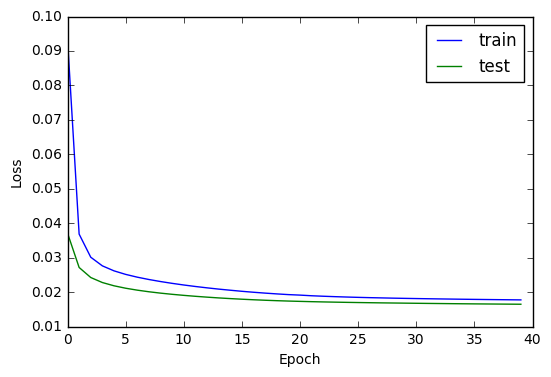

In [11]:
# Design LSTM neural network


# Define the network using the Sequential Keras API
model = Sequential()

# Inform algorithm that -1 represents non-values
model.add(Masking(mask_value=-1, input_shape=(train_ind.shape[1], train_ind.shape[2])))

# Define as LSTM with 9 neurons - not optimized - use 9 because I have 9 statistical categories
model.add(LSTM(9))

# I'm not even sure why I need this part, but it doesn't work without it...
model.add(Dense(train_ind.shape[1]))

# Define a loss function and the Adam optimization algorithm
model.compile(loss='mean_squared_error', optimizer='adam')


# train network
history = model.fit(train_ind, train_resp, epochs=40, batch_size=25, validation_data=(test_ind, test_resp),verbose=0, shuffle=False)


# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model is trained!

Let's make a prediction.

In [12]:
predicted_resp = model.predict(predictfrom_ind)

# Show the shape of the prediction array
print("predicted_resp.shape = ",predicted_resp.shape)

predicted_resp.shape =  (165, 3)


The ML algorithm expects values between -1 and 1, and that's what it returns as well. These predicted values must be un-scaled. To facilitate un-scaling, the dimensionality of the prediction must be adjusted. Do so, then unscale:

In [13]:
# Make prediced_resp dimension match predictfrom_ind
predicted_resp = np.expand_dims(predicted_resp,axis=2)


# Invert scaling for forecast

# Add the predicted values to the independent variables used for the prediction
inv_predicted = np.concatenate((predictfrom_ind[:,:,:],predicted_resp), axis=2)

# Invert the 3D array one lag at a time
for i in range(inv_predicted.shape[1]):
    inv_predicted[:,i,:] = scaler.inverse_transform(inv_predicted[:,i,:])
results1 = inv_predicted[:,:,:]

# Isolate the predicted values
inv_predicted_resp = inv_predicted[:,:,-1]


# Now, invert scaling for predictfrom
inv_predictfrom = np.empty_like(predictfrom)
for i in range(predictfrom.shape[1]):
    inv_predictfrom[:,i,:] = scaler.inverse_transform(predictfrom[:,i,:])
actual_resp = inv_predictfrom[:,:,-1]

## 4. Evaluate model performance

We'll compare the predicted to the actual performance using Root Mean Square Error (RMSE) and a chart. Minimizing RMSE is ideal.

I find plotting predicted vs actual performance is useful, especially when a 1:1 line is added. Points above the line have been over-predicted, and points below and under-predicted.



In [14]:
# calculate RMSE
rmseALL = np.sqrt(mean_squared_error(inv_predicted_resp, actual_resp))
print('Overall RMSE: %.3f' % rmseALL)
rmselag1 = np.sqrt(mean_squared_error(inv_predicted_resp[:,0], actual_resp[:,0]))
print('Lag1 RMSE: %.3f' % rmselag1)
rmselag2 = np.sqrt(mean_squared_error(inv_predicted_resp[:,1], actual_resp[:,1]))
print('Lag2 RMSE: %.3f' % rmselag2)
rmselag3 = np.sqrt(mean_squared_error(inv_predicted_resp[:,2], actual_resp[:,2]))
print('Lag3 RMSE: %.3f' % rmselag3)

Overall RMSE: 16.143
Lag1 RMSE: 16.594
Lag2 RMSE: 16.169
Lag3 RMSE: 15.651


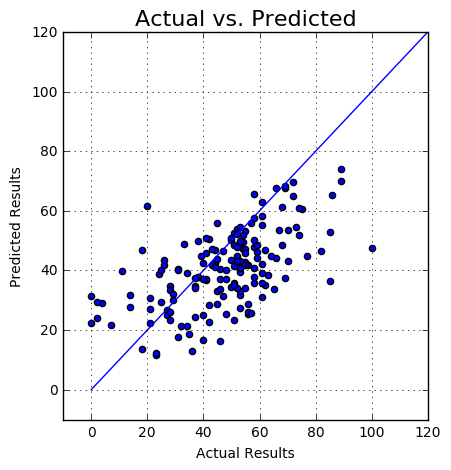

In [15]:
fig1 = plt.figure(figsize=(16,5))
az = fig1.add_subplot(1,3,3)
az.scatter(actual_resp[:,0],inv_predicted_resp[:,0],c="b")
#az.scatter(actual_resp[:,1],inv_predicted_resp[:,1],c="r")
#az.scatter(actual_resp[:,2],inv_predicted_resp[:,2],c="g")
az.plot([0,50,120],[0,50,120])
plt.ylim(-10,120)
plt.xlim(-10,120)
plt.xlabel('Actual Results')
plt.ylabel('Predicted Results')
plt.title('Actual vs. Predicted', fontsize=16)
plt.grid(True)

If you haven't already, read the blog post associated with this notebook at 

https://scibbatical.wordpress.com/2018/02/27/building-a-fantasy-hockey-beater/

### Load the magazine predictions

The predictions from several forecaster magazines are recorded in a .csv file. Load it to compare to the ML predictions.

The .csv file has a header row and then a number of player records.

In [16]:
forecasts = np.array(pd.read_csv('2016_Predictions_skater_withPlayerID.csv',header=None))

print(forecasts[0])
print(forecasts[1])
print(forecasts.shape)

['Last Name' 'First Name' 'Full Name' 'Team' 'Pos' 'Hockey News' 'Poolers'
 'Forecaster' 'PlayerID']
['Lindell' 'Esa' 'Esa Lindell' 'Dal' 'D' '26' '23' '17' '8476902']
(293, 9)


These forecasts need to be matched to the ML ones by player ID. I'll append three columns to this forecast array: the ML prediction, the results from the previous season (20152016) and the actual results for 20162017.

In [17]:
toappend = np.empty((forecasts.shape[0],3))
toappend[:] = np.nan # I'll set these to be nans for now. I think pyplot should ignore nans...

forecasts = np.append(forecasts, toappend, axis=1)

Let's extract the header, then delete that header row from _forecasts_.

In [18]:
header = forecasts[0]
header[-3], header[-2], header[-1] = 'ML', '20152016', 'Actual'

forecasts = np.delete(forecasts,0,0)

print(header)

['Last Name' 'First Name' 'Full Name' 'Team' 'Pos' 'Hockey News' 'Poolers'
 'Forecaster' 'PlayerID' 'ML' '20152016' 'Actual']


Where possible, use the data from the ML exercise to populate the new columns in _forecasts_.

In [19]:
for i in forecasts[:,8]:
    if float(i) in inv_predicted[:,0,8]:
        forecasts[forecasts[:,8].tolist().index(i),9] = inv_predicted[inv_predicted[:,0,8].tolist().index(float(i)),0,9]
        forecasts[forecasts[:,8].tolist().index(i),10] = inv_predicted[inv_predicted[:,0,8].tolist().index(float(i)),0,1]
        forecasts[forecasts[:,8].tolist().index(i),11] = inv_predictfrom[inv_predictfrom[:,0,8].tolist().index(float(i)),0,-1]

Plot the comparison of predicted vs forecast for ML, and 3 prediction mags. Also, compare to production from the previous season (perhaps the most basic forecast available?).

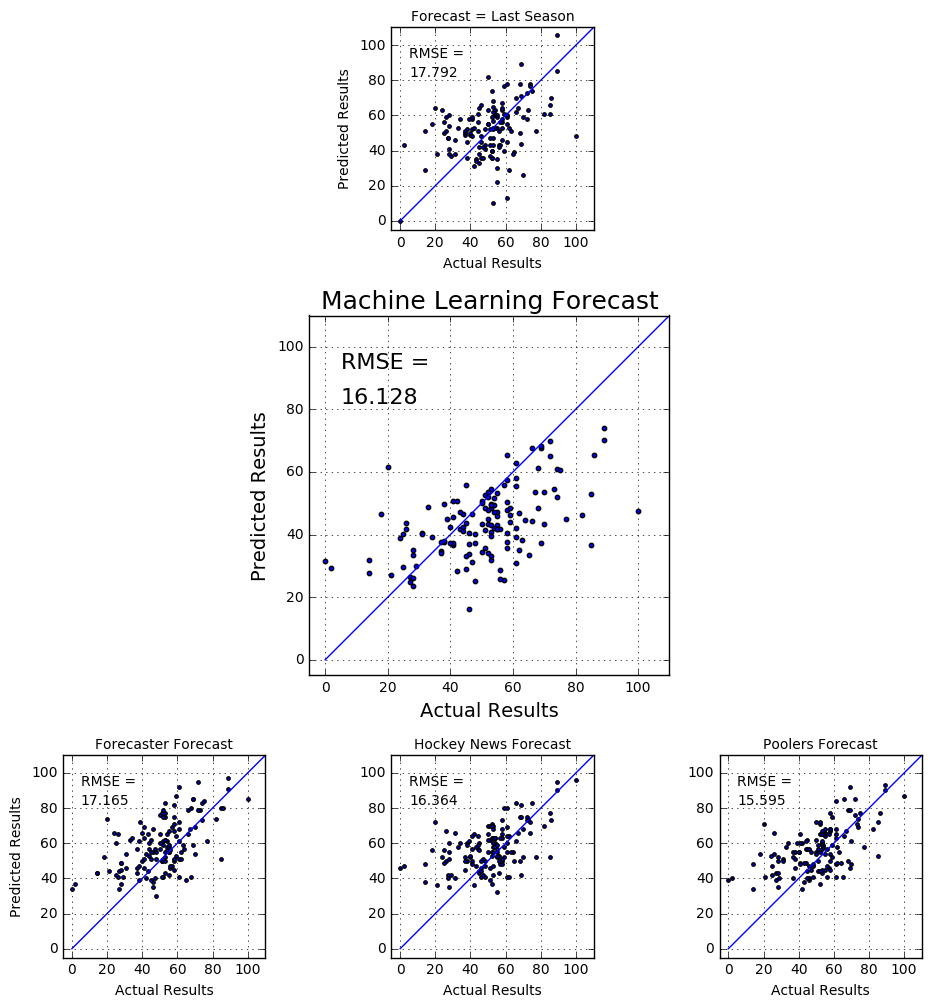

In [20]:

fig1 = plt.figure(figsize=(12,12))

az = fig1.add_axes([0.36, 0.36, 0.3, 0.3]) # left, bottom, width, height (range 0 to 1)

az.scatter(forecasts[:,11],forecasts[:,9],c="b",s=10)
az.plot([0,50,120],[0,50,120])
az.set_xlim(-5,110)
az.set_ylim(-5,110)
az.set_aspect('equal')
plt.xlabel('Actual Results', fontsize=14)
plt.ylabel('Predicted Results', fontsize=14)
plt.title('Machine Learning Forecast', fontsize=18)
az.annotate('RMSE =', xy=(5, 93),fontsize=16)
az.annotate(round(np.sqrt(mean_squared_error(forecasts[~np.isnan(forecasts[:,11].astype(float)),11],forecasts[~np.isnan(forecasts[:,11].astype(float)),9])),3), xy=(5, 82),fontsize=16)
plt.grid(True)

ay = fig1.add_subplot(4,3,2)
ay.scatter(forecasts[:,11],forecasts[:,10],c="b",s=6)
ay.plot([0,50,120],[0,50,120])
ay.set_xlim(-5,110)
ay.set_ylim(-5,110)
ay.set_aspect('equal')
plt.xlabel('Actual Results')
plt.ylabel('Predicted Results')
plt.title('Forecast = Last Season', fontsize=10)
ay.annotate('RMSE =', xy=(5, 93))
ay.annotate(round(np.sqrt(mean_squared_error(forecasts[~np.isnan(forecasts[:,11].astype(float)),11],forecasts[~np.isnan(forecasts[:,11].astype(float)),10])),3), xy=(5, 82))
plt.grid(True)

ax = fig1.add_subplot(4,3,12)
ax.scatter(forecasts[:,11],forecasts[:,6],c="b",s=6)
ax.plot([0,50,120],[0,50,120])
ax.set_xlim(-5,110)
ax.set_ylim(-5,110)
ax.set_aspect('equal')
plt.xlabel('Actual Results')
#plt.ylabel('Predicted Results')
plt.title('Poolers Forecast', fontsize=10)
ax.annotate('RMSE =', xy=(5, 93))
ax.annotate(round(np.sqrt(mean_squared_error(forecasts[~np.isnan(forecasts[:,11].astype(float)),11],forecasts[~np.isnan(forecasts[:,11].astype(float)),6])),3), xy=(5, 82))
plt.grid(True)

aw = fig1.add_subplot(4,3,11)
aw.scatter(forecasts[:,11],forecasts[:,5],c="b",s=6)
aw.plot([0,50,120],[0,50,120])
aw.set_xlim(-5,110)
aw.set_ylim(-5,110)
aw.set_aspect('equal')
plt.xlabel('Actual Results')
#plt.ylabel('Predicted Results')
plt.title('Hockey News Forecast', fontsize=10)
aw.annotate('RMSE =', xy=(5, 93))
aw.annotate(round(np.sqrt(mean_squared_error(forecasts[~np.isnan(forecasts[:,11].astype(float)),11],forecasts[~np.isnan(forecasts[:,11].astype(float)),5])),3), xy=(5, 82))
plt.grid(True)

aw = fig1.add_subplot(4,3,10)
aw.scatter(forecasts[:,11],forecasts[:,7],c="b",s=6)
aw.plot([0,50,120],[0,50,120])
aw.set_xlim(-5,110)
aw.set_ylim(-5,110)
aw.set_aspect('equal')
plt.xlabel('Actual Results')
plt.ylabel('Predicted Results')
plt.title('Forecaster Forecast', fontsize=10)
aw.annotate('RMSE =', xy=(5, 93))
aw.annotate(round(np.sqrt(mean_squared_error(forecasts[~np.isnan(forecasts[:,11].astype(float)),11],forecasts[~np.isnan(forecasts[:,11].astype(float)),7])),3), xy=(5, 82))
plt.grid(True)

#plt.tight_layout()

As an illustration, create a plot that identifies areas of over- and under-prediction:

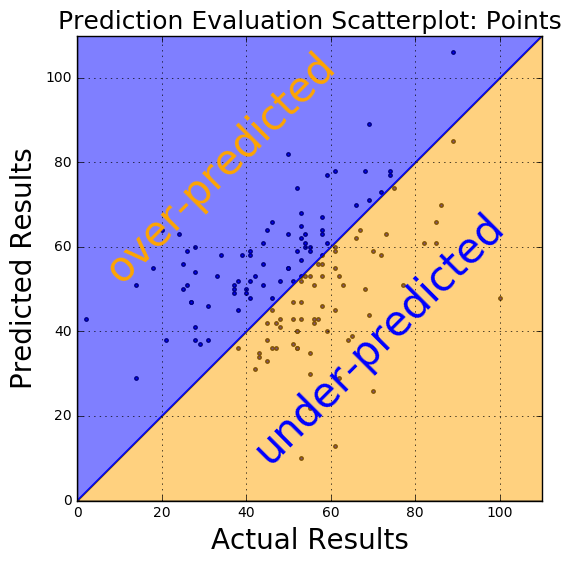

In [21]:
fig = plt.figure(figsize=(6,6))

az = fig.add_subplot(1,1,1)
az.scatter(forecasts[:,11],forecasts[:,10],c="b",s=6)
az.plot([0,50,120],[0,50,120])
az.fill_between([0,50,120],[0,50,120],110,facecolor='blue',alpha=0.5)
az.fill_between([0,50,120],[0,50,120],0,facecolor='orange',alpha=0.5)
az.set_xlim(0,110)
az.set_ylim(0,110)
az.set_aspect('equal')
plt.xlabel('Actual Results', fontsize=20)
plt.ylabel('Predicted Results', fontsize=20)
plt.title('Prediction Evaluation Scatterplot: Points', fontsize=18)
az.annotate('over-predicted', xy=(5, 100),color='orange',fontsize=30,rotation=45)
az.annotate('under-predicted', xy=(40, 62),color='blue',fontsize=30,rotation=45)
plt.grid(True)